In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller 
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
from pmdarima import auto_arima





In [2]:
df=pd.read_csv('Kiriwaneliya_project.csv')
df.head()





,Year,Month,Rainfall,Temp_min,Temp_max,Hum_min,Hum_max
0,2010,January,104.699999,11.0,20.2,NaN,NaN
1,2010,February,34.600000,12.0,22.1,NaN,NaN
2,2010,March,128.300001,11.5,23.0,NaN,NaN
3,2010,April,153.200000,13.1,22.5,NaN,NaN
4,2010,May,174.300002,14.1,21.7,NaN,NaN


In [3]:
df["Time"]=df["Year"].astype(str)+"-"+df["Month"].astype(str)


In [4]:
df.head()

,Year,Month,Rainfall,Temp_min,Temp_max,Hum_min,Hum_max,Time
0,2010,January,104.699999,11.0,20.2,NaN,NaN,2010-January
1,2010,February,34.600000,12.0,22.1,NaN,NaN,2010-February
2,2010,March,128.300001,11.5,23.0,NaN,NaN,2010-March
3,2010,April,153.200000,13.1,22.5,NaN,NaN,2010-April
4,2010,May,174.300002,14.1,21.7,NaN,NaN,2010-May


In [5]:
hum_max=df[["Time","Hum_max"]]
hum_max.head()

,Time,Hum_max
0,2010-January,NaN
1,2010-February,NaN
2,2010-March,NaN
3,2010-April,NaN
4,2010-May,NaN


In [6]:
hum_max['Time']=pd.to_datetime(hum_max['Time'])

<ipython-input-6-14e8545da2ed>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hum_max['Time']=pd.to_datetime(hum_max['Time'])


In [7]:
hum_max.head()

,Time,Hum_max
0,2010-01-01,NaN
1,2010-02-01,NaN
2,2010-03-01,NaN
3,2010-04-01,NaN
4,2010-05-01,NaN


In [8]:
#Checking for missing values
hum_max.isna().sum()

Time        0
Hum_max    15
dtype: int64

In [10]:
#Setting the time index
hum_max.set_index('Time',inplace=True)

In [11]:
hum_max=hum_max.resample('MS').first()

In [12]:
#removing missing values
hum=hum_max.fillna(method='bfill')
hum.head(20)


,Hum_max
Time,
2010-01-01,87.0
2010-02-01,87.0
2010-03-01,87.0
2010-04-01,87.0
2010-05-01,87.0
2010-06-01,87.0
2010-07-01,87.0
2010-08-01,87.0
2010-09-01,87.0


In [13]:
hum = hum.rename(columns = {'Hum_max': 'Humidity'})
hum.head()

,Humidity
Time,
2010-01-01,87.0
2010-02-01,87.0
2010-03-01,87.0
2010-04-01,87.0
2010-05-01,87.0


In [14]:
hum.columns

Index(['Humidity'], dtype='object')

In [15]:
hum.head()

,Humidity
Time,
2010-01-01,87.0
2010-02-01,87.0
2010-03-01,87.0
2010-04-01,87.0
2010-05-01,87.0


<AxesSubplot:xlabel='Time'>

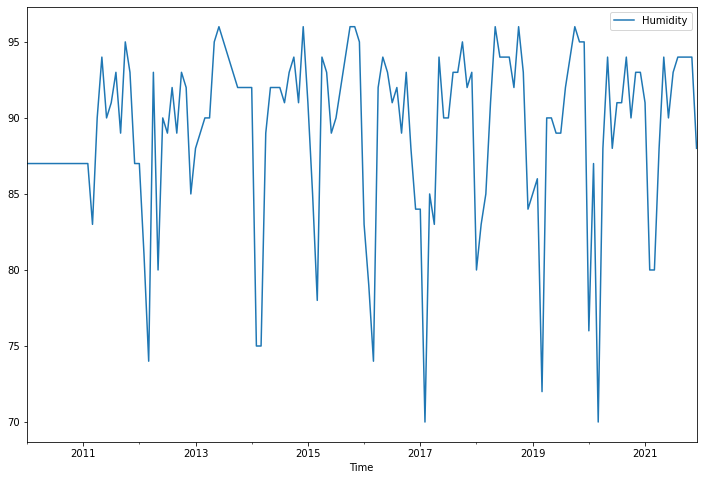

In [16]:
hum.plot(figsize=(12,8))

No trend. But some evidence for seasonality

# Testing For Stationarity

In [17]:
### ADF Test
test_result=adfuller(hum['Humidity'])
#Ho: The series is non stationary
#H1: The series is stationary

def adfuller_test(x):
    result=adfuller(x)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    
adfuller_test(hum['Humidity'])


ADF Test Statistic : -3.915328826299299
p-value : 0.0019248872857450627
#Lags Used : 14
Number of Observations Used : 129
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [18]:
# KPSS test
from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(hum['Humidity'])


KPSS Statistic: 0.06703537726054845
p-value: 0.1
num lags: 3
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


C:\Users\isuru\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [19]:
#PhillipsPerron Test
from arch.unitroot import PhillipsPerron

pp = PhillipsPerron(hum['Humidity'].astype(float))
print(pp.summary().as_text())


     Phillips-Perron Test (Z-tau)    
Test Statistic                 -7.293
P-value                         0.000
Lags                               14
-------------------------------------

Trend: Constant
Critical Values: -3.48 (1%), -2.88 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


C:\Users\isuru\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


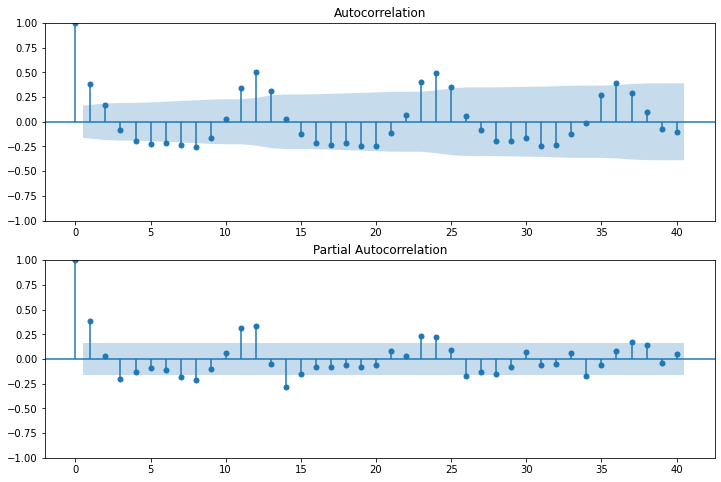

In [20]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(hum['Humidity'],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(hum['Humidity'],lags=40,ax=ax2)


According to the PACF and ACF plots, series is likely to follow a MA process. But since we are following step-wise, better to start with p=3,q=3, d=0

In [23]:
arima_model=auto_arima(hum['Humidity'].astype(float),start_p=0,start_q=0,max_p=5,max_q=3,start_P=0,start_Q=0,max_P=3,max_Q=3,m=12,seasonal=True,error_action='warn',trace=True,supress_warnings=True,stepwise=True,random_state=20,n_fits=50)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=908.047, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=863.041, Time=1.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=877.373, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1704.551, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=887.244, Time=0.15 sec


C:\Users\isuru\anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(1,0,0)(2,0,0)[12] intercept (if you do not want to see these warnings, run with error_action="ignore").
  warnings.warn(warning_str, ModelFitWarning)


 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=870.459, Time=1.17 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=873.177, Time=0.70 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=858.051, Time=4.54 sec
 ARIMA(1,0,0)(3,0,1)[12] intercept   : AIC=853.638, Time=8.13 sec
 ARIMA(1,0,0)(3,0,0)[12] intercept   : AIC=866.897, Time=6.43 sec
 ARIMA(1,0,0)(3,0,2)[12] intercept   : AIC=inf, Time=9.29 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=906.013, Time=6.30 sec
 ARIMA(0,0,0)(3,0,1)[12] intercept   : AIC=inf, Time=5.75 sec
 ARIMA(2,0,0)(3,0,1)[12] intercept   : AIC=850.820, Time=8.36 sec
 ARIMA(2,0,0)(2,0,1)[12] intercept   : AIC=855.547, Time=5.14 sec
 ARIMA(2,0,0)(3,0,0)[12] intercept   : AIC=859.845, Time=6.88 sec
 ARIMA(2,0,0)(3,0,2)[12] intercept   : AIC=inf, Time=10.74 sec


C:\Users\isuru\anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(2,0,0)(2,0,0)[12] intercept (if you do not want to see these warnings, run with error_action="ignore").
  warnings.warn(warning_str, ModelFitWarning)


 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(2,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=8.08 sec
 ARIMA(3,0,0)(3,0,1)[12] intercept   : AIC=855.273, Time=10.47 sec
 ARIMA(2,0,1)(3,0,1)[12] intercept   : AIC=852.278, Time=11.05 sec
 ARIMA(1,0,1)(3,0,1)[12] intercept   : AIC=853.938, Time=8.92 sec
 ARIMA(3,0,1)(3,0,1)[12] intercept   : AIC=852.276, Time=12.62 sec
 ARIMA(2,0,0)(3,0,1)[12]             : AIC=inf, Time=10.25 sec

Best model:  ARIMA(2,0,0)(3,0,1)[12] intercept
Total fit time: 139.925 seconds


# Forecast using the model

In [24]:
model=sm.tsa.statespace.SARIMAX(hum["Humidity"].astype('float'),order=(2, 0, 0),seasonal_order=(3,0,1,12))
results=model.fit()
results.summary()


C:\Users\isuru\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\isuru\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                             Humidity   No. Observations:                  144
Model:             SARIMAX(2, 0, 0)x(3, 0, [1], 12)   Log Likelihood                -430.254
Date:                              Wed, 13 Apr 2022   AIC                            874.507
Time:                                      23:12:36   BIC                            895.296
Sample:                                  01-01-2010   HQIC                           882.955
                                       - 12-01-2021                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4263      0.067      6.384      0.000       0.295       0.557
ar.L2          0.5541      0.066      8.402      0.000       0.425       0.683
ar.S.L12       1.0600      0.136      7.775      0.000       0.793       1.327
ar.S.L24      -0.0277      0.107     -0.260      0.795      -0.237       0.181
ar.S.L36      -0.0344      0.093     -0.371      0.711      -0.216       0.147
ma.S.L12      -0.9361      0.308     -3.041      0.002      -1.539      -0.333
sigma2        19.1537      4.476      4.280      0.000      10.382      27.926
===================================================================================
Ljung-Box (L1) (Q):                   2.04   Jarque-Bera (JB):                21.20
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):               1.58   Skew:                            -0.49
Prob(H) (two-sided):                  0.12   Kurtosis:                         4.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='Time'>

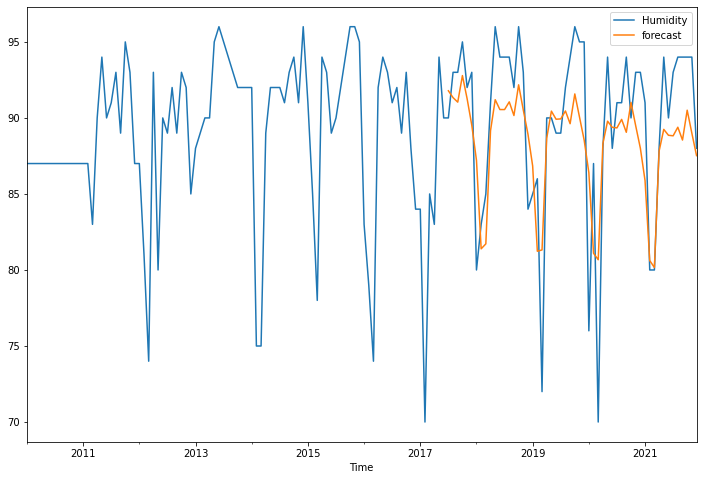

In [29]:
hum['forecast']=results.predict(start=90,end=144,dynamic=True)
hum[['Humidity','forecast']].plot(figsize=(12,8))


In [28]:
hum.tail()


,Humidity,forecast
Time,,
2021-08-01,94.0,89.387524
2021-09-01,94.0,88.545937
2021-10-01,94.0,NaN
2021-11-01,94.0,NaN
2021-12-01,88.0,NaN
